<a href="https://colab.research.google.com/github/mikedoucerain/CapstoneMcgill2019/blob/master/pompiers_20190722_1911.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
%env project='datacapstoneproject2'

env: project='datacapstoneproject2'


In [0]:
import numpy as np
import pandas as pd

df_incidents = pd.read_csv('http://donnees.ville.montreal.qc.ca/dataset/701683f0-a838-4fe0-b4d6-a4964d9ea7f0/resource/9e67d2f3-9104-4af4-aac4-022df621a749/download/donneesouvertes-interventions-sim.csv', sep=",")


In [0]:
df_incidents['NOM_ARROND'] = np.where(df_incidents['NOM_ARROND']=="Indéterminé", df_incidents['NOM_VILLE'], df_incidents['NOM_ARROND'])

In [0]:
df_incidents['NOM_ARROND'].replace( to_replace=' / ', value= '-', regex=True, inplace=True )

In [0]:
df_incidents['NOM_ARROND'].replace( to_replace='St', value= 'Saint', regex=True, inplace=True )

In [0]:
df_incidents.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE
0,1168,2015-01-03T20:56:02,Premier répondant,1-REPOND,33,Montréal,Sud-Ouest,8,1.0,1.0,297283.0,5035433.1,-73.596117,45.458786
1,1171,2015-01-03T21:03:52,Alarme privé ou locale,Alarmes-incendies,22,Montréal,Saint-Léonard,4,4.0,1.0,299180.0,5049284.2,-73.572020,45.583442
2,1172,2015-01-03T21:07:00,Premier répondant,1-REPOND,9,Montréal,Villeray-Saint-Michel-Parc Extension,4,1.0,1.0,297259.6,5046768.2,-73.596589,45.560784
3,1177,2015-01-03T21:41:46,Premier répondant,1-REPOND,37,Montréal,Villeray-Saint-Michel-Parc Extension,4,1.0,1.0,294738.3,5044817.2,-73.628847,45.543197
4,1178,2015-01-03T21:43:32,Aliments surchauffés,SANS FEU,16,Montréal,Plateau Mont-Royal,11,5.0,1.0,298505.7,5042556.1,-73.580573,45.522895


In [0]:
df_crime = pd.read_csv('http://donnees.ville.montreal.qc.ca/dataset/5829b5b0-ea6f-476f-be94-bc2b8797769a/resource/c6f482bf-bf0f-4960-8b2f-9982c211addd/download/interventionscitoyendo.csv', sep=",", encoding = "ISO-8859-1")
df_crime.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
3,Méfait,2017-07-21,jour,21.0,0.000000,0.000000e+00,1.000000,1.000000
4,Méfait,2017-07-29,jour,12.0,0.000000,0.000000e+00,1.000000,1.000000


In [0]:
df_caserne = pd.read_csv('http://donnees.ville.montreal.qc.ca/dataset/c69e78c6-e454-4bd9-9778-e4b0eaf8105b/resource/f6542ad1-31f5-458e-b33d-1a028fab3e98/download/casernes.csv', sep=",")
df_caserne.head()

,CASERNE,NO_CIVIQUE,RUE,LATITUDE,LONGITUDE,ARRONDISSEMENT,VILLE,DATE_DEBUT,DATE_FIN,MTM8_X,MTM8_Y
0,3,256,rue Young,45.493454,-73.560172,LE SUD-OUEST,NaN,2015-01-01T07:00:00,NaN,300097.0,5039283.0
1,15,1255,rue de la Sucrerie,45.484419,-73.560917,LE SUD-OUEST,NaN,2015-01-01T07:00:00,NaN,300038.0,5038279.0
2,23,523,place Saint-Henri,45.477925,-73.585251,LE SUD-OUEST,NaN,2015-01-01T07:00:00,NaN,298135.0,5037559.0
3,33,6040,boulevard Monk,45.457841,-73.595450,LE SUD-OUEST,NaN,2015-01-01T07:00:00,NaN,297335.0,5035328.0
4,9,8100,boulevard Saint-Michel,45.563748,-73.610169,VILLERAY-SAINT-MICHEL-PARC-EXTENSION,NaN,2019-05-06T07:00:00,NaN,296200.0,5047099.0


In [0]:
df_valuationfonciere = pd.read_csv('http://donnees.ville.montreal.qc.ca/dataset/4ad6baea-4d2c-460f-a8bf-5d000db498f7/resource/2b9dfc3d-91d3-48de-b32c-a2a6d9417079/download/uniteevaluationfonciere.csv', sep=",")

df_valuationfonciere.head()

,ID_UEV,CIVIQUE_DEBUT,CIVIQUE_FIN,NOM_RUE,SUITE_DEBUT,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,ANNEE_CONSTRUCTION,CODE_UTILISATION,LIBELLE_UTILISATION,CATEGORIE_UEF,MATRICULE83,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NO_ARROND_ILE_CUM
0,5212233,2544,2544,avenue Fletcher (MTL),206,50,1.0,1.0,2012.0,1000,Logement,Condominium,0352-50-0581-9-004-0004,39.0,NaN,REM22
1,5008765,1908,1908,boulevard Guy-Bouchard (LSL),NaN,50,1.0,1.0,1997.0,1000,Logement,Condominium,9633-18-7365-1-001-0007,71.0,438.0,REM17
2,4077093,72,72,15e Rue (ROX),NaN,50,1.0,1.0,1958.0,1000,Logement,Régulier,8140-12-5372-9-000-0000,809.0,120.0,REM31
3,4010900,105,105,avenue Parkdale (PCL),NaN,20,1.0,1.0,1974.0,1000,Logement,Régulier,8135-34-5735-1-000-0000,662.0,102.0,REM99
4,4078604,45,45,13e Avenue (ROX),NaN,50,1.0,1.0,1955.0,1000,Logement,Régulier,8140-04-4474-1-000-0000,871.0,108.0,REM31


In [0]:
import requests, zipfile, io


In [0]:
!pip install geopandas

In [0]:
!pip install Rtree

In [0]:
!sudo apt install python3-rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


**Join interventions with Valuation Foncieres**

In [0]:
import pandas
import geopandas
import geopandas.tools
from shapely.geometry import Point

# Create the geometry column from the coordinates
# Remember that longitude is east-west (i.e. X) and latitude is north-south (i.e. Y)
df_incidents["geometry"] = df_incidents.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)



# Load the countries polygons
r = requests.get('http://donnees.ville.montreal.qc.ca/dataset/4ad6baea-4d2c-460f-a8bf-5d000db498f7/resource/866a3dbc-8b59-48ff-866d-f2f9d3bbee9d/download/uniteevaluationfonciere.geojson.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
df_geo_valuationfoncieres = geopandas.GeoDataFrame.from_file("uniteevaluationfonciere.geojson")

df_incidents.dropna(subset=["LONGITUDE", "LATITUDE"])

df_geo_incidents = geopandas.GeoDataFrame(df_incidents, geometry="geometry")

In [0]:


# Declare the coordinate system for the places GeoDataFrame
# GeoPandas doesn't do any transformations automatically when performing
# the spatial join. The layers are already in the same CRS (WGS84) so no
# transformation is needed.
df_geo_incidents.crs = {"init": "epsg:4326"}


# Perform the spatial join
df_geojoin_incidents_valuation_foncieres = geopandas.tools.sjoin(df_geo_incidents, df_geo_valuationfoncieres, op='within')

# Print the results...
df_geojoin_incidents_valuation_foncieres.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE,geometry,index_right,ID_UEV,CIVIQUE_DEBUT,CIVIQUE_FIN,NOM_RUE,SUITE_DEBUT,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,ANNEE_CONSTRUCTION,CODE_UTILISATION,LIBELLE_UTILISATION,CATEGORIE_UEF,MATRICULE83,SUPERFICIE_TERRAIN,NO_ARROND_ILE_CUM,SUPERFICIE_BATIMENT
14,1599,2015-01-04T15:35:19,Feu de champ *,AUTREFEU,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0
12282,83181,2015-08-26T11:20:04,Premier répondant,1-REPOND,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0
52078,47468,2015-05-15T22:39:13,Ac.véh./1R/s.v./bat/29B/D,1-REPOND,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0
99668,95592,2016-09-22T11:55:23,Alarme privé ou locale,Alarmes-incendies,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0
101994,48819,2016-05-19T13:15:30,Premier répondant,1-REPOND,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0


**Calculate nearest caserne**

In [0]:
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint

df_caserne["geometry"] = df_caserne.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_geo_caserne = geopandas.GeoDataFrame(df_caserne, geometry="geometry")

gpd2_pts_list = df_geo_caserne.geometry.tolist()
gpd2_pts = MultiPoint(gpd2_pts_list)
def nearest(point, gpd2_pts, gpd2=df_geo_caserne, geom_col='geometry', src_col='CASERNE'):
     # find the nearest point
     nearest_point = nearest_points(point, gpd2_pts)[1]
     # return the corresponding value of the src_col of the nearest point
     value = gpd2[gpd2[geom_col] == nearest_point][src_col].get_values()[0]
     return value

df_geojoin_incidents_valuation_foncieres['NEAREST_CASERNE'] = df_geojoin_incidents_valuation_foncieres.apply(lambda x: nearest(x.geometry, gpd2_pts), axis=1)

In [0]:
gdf_incidents_valeur_fonciere_caserne = pd.merge(df_geojoin_incidents_valuation_foncieres, df_geo_caserne, left_on='NEAREST_CASERNE', right_on='CASERNE', how='left')

**calculate distance from nearest caserne**

In [0]:
import geopy.distance

gdf_incidents_valeur_fonciere_caserne['DISTANCE_CASERNE'] = gdf_incidents_valeur_fonciere_caserne.apply(lambda x: geopy.distance.vincenty((x['LONGITUDE_x'],x['LATITUDE_x']), (x['LONGITUDE_y'],x['LATITUDE_y'])).km, axis=1)

In [0]:
gdf_incidents_valeur_fonciere_caserne.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE_x,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,CIV,MTM8_X_x,MTM8_Y_x,LONGITUDE_x,LATITUDE_x,geometry_x,index_right,ID_UEV,CIVIQUE_DEBUT,CIVIQUE_FIN,NOM_RUE,SUITE_DEBUT,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,ANNEE_CONSTRUCTION,CODE_UTILISATION,LIBELLE_UTILISATION,CATEGORIE_UEF,MATRICULE83,SUPERFICIE_TERRAIN,NO_ARROND_ILE_CUM,SUPERFICIE_BATIMENT,NEAREST_CASERNE,CASERNE_y,NO_CIVIQUE,RUE,LATITUDE_y,LONGITUDE_y,ARRONDISSEMENT,VILLE,DATE_DEBUT,DATE_FIN,MTM8_X_y,MTM8_Y_y,geometry_y,DISTANCE_CASERNE
0,1599,2015-01-04T15:35:19,Feu de champ *,AUTREFEU,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0,53,53,310,Beaurepaire drive,45.428789,-73.868415,NaN,BEACONSFIELD,2015-01-01T07:00:00,NaN,275972.0,5032161.0,POINT (-73.86841507687801 45.4287888241933),0.299797
1,83181,2015-08-26T11:20:04,Premier répondant,1-REPOND,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0,53,53,310,Beaurepaire drive,45.428789,-73.868415,NaN,BEACONSFIELD,2015-01-01T07:00:00,NaN,275972.0,5032161.0,POINT (-73.86841507687801 45.4287888241933),0.299797
2,47468,2015-05-15T22:39:13,Ac.véh./1R/s.v./bat/29B/D,1-REPOND,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0,53,53,310,Beaurepaire drive,45.428789,-73.868415,NaN,BEACONSFIELD,2015-01-01T07:00:00,NaN,275972.0,5032161.0,POINT (-73.86841507687801 45.4287888241933),0.299797
3,95592,2016-09-22T11:55:23,Alarme privé ou locale,Alarmes-incendies,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0,53,53,310,Beaurepaire drive,45.428789,-73.868415,NaN,BEACONSFIELD,2015-01-01T07:00:00,NaN,275972.0,5032161.0,POINT (-73.86841507687801 45.4287888241933),0.299797
4,48819,2016-05-19T13:15:30,Premier répondant,1-REPOND,53,Beaconsfield,Beaconsfield,2,1.0,1.0,276170.9,5031835.0,-73.865855,45.425863,POINT (-73.86585500000001 45.425863),6517,04072041,303,303,boulevard Beaconsfield (BCF),None,03,NaN,NaN,1986.0,7111,Bibliothèque,Régulier,7631-19-0302-5-000-0000,120741.0,REM99,342.0,53,53,310,Beaurepaire drive,45.428789,-73.868415,NaN,BEACONSFIELD,2015-01-01T07:00:00,NaN,275972.0,5032161.0,POINT (-73.86841507687801 45.4287888241933),0.299797


In [0]:
df_arrondissement = pd.read_csv('http://donnees.ville.montreal.qc.ca/dataset/ddfdbcd9-de86-4b44-9b41-c293d7bfef14/resource/87af3a62-ee9a-40ad-b7d9-517ab3f12fad/download/liste-arrondissements.csv', sep=",")
df_arrondissement.head()

,Nom officiel,Nom abrégé,Acronyme,Code 3L,ID-uadm,No-arro-élection,Code REM
0,Ahuntsic-Cartierville,AHUNTSIC-CARTIE,AC,AHU,56,1,REM23
1,Anjou,ANJOU,ANJ,ANJ,79,2,REM09
2,Côte-des-Neiges–Notre-Dame-de-Grâce,CDN-NDG,CDNNDG,CDN,59,3,REM34
3,Lachine,LACHINE,LAC,LAC,88,4,REM27
4,LaSalle,LASALLE,LAS,LAS,89,5,REM17


In [0]:
!pip install geocoder

**Montreal Socio Economic Cultural Demographic Data**

In [0]:
!pip install pyexcel pyexcel-xls pyexcel-xlsx

In [0]:
import pyexcel as p
import requests
url = 'http://ville.montreal.qc.ca/pls/portal/url/ITEM/55637C4923B8B03EE0530A930132B03E'  
r = requests.get(url)

with open('ANNUAIRE_STATISTIQUE_DE_LAGGLOMERATION_DE MONTREAL_RECENSEMENT_DE_2016.xls', 'wb') as f:  
    f.write(r.content)


In [0]:
#from google.colab import files
#uploaded2 = files.upload()
p.save_book_as(file_name='ANNUAIRE_STATISTIQUE_DE_LAGGLOMERATION_DE MONTREAL_RECENSEMENT_DE_2016.xls',
               dest_file_name='ANNUAIRE_STATISTIQUE_DE_LAGGLOMERATION_DE MONTREAL_RECENSEMENT_DE_2016.xlsx')

In [0]:
import openpyxl
wb = openpyxl.load_workbook("ANNUAIRE_STATISTIQUE_DE_LAGGLOMERATION_DE MONTREAL_RECENSEMENT_DE_2016.xlsx")

In [0]:
def reformatCensusDataFrame(ws,columns_length):
  data = ws.values
  df = pd.DataFrame(data)
  df = df[1:]
  df.drop(df.columns[columns_length:],axis=1,inplace=True)
  new_header = df.iloc[1] 
  df = df[2:] 
  df.columns = new_header 
  colNames = df.columns
  for i in range(len(colNames)):
    colName = colNames[i]
    if i == 0:
      df.columns.values[i] = 'District'
    else:
      if str(colName) == "None":
        colName = colNames[(i-1)]+' %'
      if str(colName) == "nan":
        colName = colNames[(i-1)]+' %'
      df.columns.values[i] = colName
  return df

In [0]:
sheets_names = wb.sheetnames


df_density = reformatCensusDataFrame(wb[sheets_names[2]],6)
df_density.head()

2,District,Population en 2016,Population en 2011,Variation 2011-2016 (en %),Superficie (en km2),Densité
3,AGGLOMÉRATION DE MONTRÉAL,1942044,1886481,2.94533,499.092,3891.15
4,Ville de Montréal,1704694,1649519,3.34491,365.165,4668.28
5,Ahuntsic-Cartierville,134245,126891,5.79553,24.16,5556.5
6,Anjou,42796,41928,2.07022,13.68,3128.36
7,Côte-des-Neiges–Notre-Dame-de-Grâce,166520,165031,0.902255,21.44,7766.79


In [0]:
df_sex = reformatCensusDataFrame(wb[sheets_names[3]],5)

In [0]:
df_age = reformatCensusDataFrame(wb[sheets_names[4]],45)
df_age.head()

2,District,0 à 4 ans,0 à 4 ans %,5 à 9 ans,5 à 9 ans %,10 à 14 ans,10 à 14 ans %,15 à 19 ans,15 à 19 ans %,20 à 24 ans,20 à 24 ans %,25 à 29 ans,25 à 29 ans %,30 à 34 ans,30 à 34 ans %,35 à 39 ans,35 à 39 ans %,40 à 44 ans,40 à 44 ans %,45 à 49 ans,45 à 49 ans %,50 à 54 ans,50 à 54 ans %,55 à 59 ans,55 à 59 ans %,60 à 64 ans,60 à 64 ans %,65 à 69 ans,65 à 69 ans %,70 à 74 ans,70 à 74 ans %,75 à 79 ans,75 à 79 ans %,80 à 84 ans,80 à 84 ans %,85 à 89 ans,85 à 89 ans %,90 à 94 ans,90 à 94 ans %,95 à 99 ans,95 à 99 ans %,100 ans et plus,100 ans et plus %,Âge moyen de la population,Âge médian de la population
3,AGGLOMÉRATION DE MONTRÉAL,109740,0.0565074,104385,0.05375,90350,0.0465231,97835,0.0503773,139720,0.0719448,153500,0.0790404,152195,0.0783684,147480,0.0759406,128970,0.0664094,125510,0.0646278,131865,0.0679001,127010,0.0654001,109825,0.0565512,95180,0.0490102,72395,0.0372777,57285,0.0294973,46700,0.0240468,32315,0.0166397,15195,0.00782423,3950,0.00203394,645,0.000332124,40.6,38.5
4,Ville de Montréal,98815,0.0579666,91005,0.0533851,75960,0.0445594,81790,0.0479794,123930,0.0726994,142395,0.0835313,141520,0.083018,134710,0.0790232,114790,0.0673378,109245,0.064085,113465,0.0665605,109565,0.0642727,94485,0.0554265,80575,0.0472667,61060,0.0358188,48665,0.0285477,39765,0.0233268,27120,0.0159091,12190,0.00715086,3140,0.00184198,510,0.000299175,40.3,37.9
5,Ahuntsic-Cartierville,8610,0.0641365,7855,0.0585124,6280,0.0467801,6435,0.0479347,7785,0.057991,8755,0.0652166,9730,0.0724794,10200,0.0759805,9415,0.070133,8790,0.0654773,8805,0.065589,8710,0.0648814,7495,0.0558308,6460,0.048121,5270,0.0392566,4440,0.0330739,4200,0.0312861,3070,0.0228686,1440,0.0107267,415,0.00309136,80,0.000595925,41.6,39.9
6,Anjou,2440,0.0570093,2605,0.0608645,2210,0.0516355,2095,0.0489486,2220,0.0518692,2050,0.0478972,2305,0.0538551,2780,0.0649533,2745,0.0641355,2895,0.0676402,2930,0.0684579,2920,0.0682243,2630,0.0614486,2460,0.0574766,2275,0.0531542,2040,0.0476636,1720,0.0401869,1070,0.025,345,0.00806075,60,0.00140187,5,0.000116822,43.9,43.8
7,Côte-des-Neiges–Notre-Dame-de-Grâce,9495,0.0570219,9285,0.0557607,8060,0.048404,9250,0.0555506,15210,0.0913431,14135,0.0848872,14000,0.0840765,13280,0.0797526,11520,0.069183,10560,0.0634177,10090,0.0605951,9330,0.056031,8205,0.0492748,7415,0.0445305,5305,0.031859,4085,0.0245323,3255,0.0195478,2345,0.0140828,1270,0.00762694,380,0.00228208,65,0.000390355,38.7,36.1


In [0]:
df_family = reformatCensusDataFrame(wb[sheets_names[6]],17)
df_family.head()

2,District,Nombre de familles,Familles de 2 personnes,Familles de 2 personnes %,Familles de 3 personnes,Familles de 3 personnes %,Familles de 4 personnes,Familles de 4 personnes %,Familles de 5 personnes ou plus,Familles de 5 personnes ou plus %,Couples sans enfants,Couples sans enfants %,Couples avec enfants,Couples avec enfants %,Familles monoparentales,Familles monoparentales %,Nombre moyen de personnes par famille
3,AGGLOMÉRATION DE MONTRÉAL,485220,240790,0.496249,109495,0.225661,93720,0.193149,41210,0.0849305,177845,0.366524,207650,0.42795,99720,0.205515,2.9
4,Ville de Montréal,419650,212385,0.5061,95130,0.226689,77705,0.185166,34430,0.0820446,155025,0.369415,174670,0.416228,89965,0.214381,2.9
5,Ahuntsic-Cartierville,32880,15255,0.46396,7690,0.233881,6790,0.206509,3150,0.0958029,11055,0.336223,15220,0.462895,6610,0.201034,3
6,Anjou,11280,5670,0.50266,2350,0.208333,2240,0.198582,1030,0.0913121,4270,0.378546,4735,0.41977,2275,0.201684,2.9
7,Côte-des-Neiges–Notre-Dame-de-Grâce,39315,18465,0.469668,9585,0.2438,7725,0.19649,3535,0.0899148,12895,0.327992,17825,0.453389,8595,0.218619,3


In [0]:
df_kids = reformatCensusDataFrame(wb[sheets_names[7]],14)

In [0]:
df_mono_parent = reformatCensusDataFrame(wb[sheets_names[8]],6)

In [0]:
df_household = reformatCensusDataFrame(wb[sheets_names[9]],13)
df_household.head()

2,District,Nombre de ménages selon la taille,Ménages composés d'une personne,Ménages composés d'une personne %,Ménages composés de 2 personnes,Ménages composés de 2 personnes %,Ménages composés de 3 personnes,Ménages composés de 3 personnes %,Ménages composés de 4 personnes,Ménages composés de 4 personnes %,Ménages composés de 5 personnes ou plus,Ménages composés de 5 personnes ou plus %,Nombre moyen de personnes dans les ménages privés
3,AGGLOMÉRATION DE MONTRÉAL,870375,342495,0.393503,259330,0.297952,118655,0.136326,97520,0.112044,52380,0.060181,2.2
4,Ville de Montréal,779795,318385,0.408293,231595,0.296995,104190,0.133612,81595,0.104636,44040,0.0564764,2.1
5,Ahuntsic-Cartierville,58985,24315,0.412223,15980,0.270916,7865,0.133339,6955,0.117911,3870,0.0656099,2.2
6,Anjou,18800,7050,0.375,5810,0.309043,2425,0.128989,2235,0.118883,1275,0.0678191,2.2
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75010,29990,0.399813,21520,0.286895,10925,0.145647,8240,0.109852,4325,0.057659,2.2


In [0]:
df_household_type = reformatCensusDataFrame(wb[sheets_names[10]],8)
df_household_type.head()

2,District,Nombre de ménages selon le genre,Ménages unifamiliaux,Ménages unifamiliaux %,Ménages multifamiliaux,Ménages multifamiliaux %,Ménages non familiaux,Ménages non familiaux %
3,AGGLOMÉRATION DE MONTRÉAL,870370,468960,0.538805,7970,0.00915703,393440,0.452038
4,Ville de Montréal,779800,405575,0.520101,6905,0.00885483,367315,0.471037
5,Ahuntsic-Cartierville,58985,31760,0.538442,550,0.0093244,26675,0.452234
6,Anjou,18800,10980,0.584043,150,0.00797872,7665,0.407713
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75005,38220,0.509566,535,0.00713286,36255,0.483368


In [0]:
df_rent_landlord = reformatCensusDataFrame(wb[sheets_names[11]],6)
df_rent_landlord.head()

2,District,Ménages privés selon le mode d'occupation,Propriétaire,Propriétaire %,Locataire,Locataire %
3,AGGLOMÉRATION DE MONTRÉAL,870375,348235,0.400098,522140,0.599902
4,Ville de Montréal,779795,286430,0.367314,493365,0.632686
5,Ahuntsic-Cartierville,58985,23135,0.392218,35850,0.607782
6,Anjou,18800,8325,0.442819,10470,0.556915
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75005,20010,0.266782,54995,0.733218


In [0]:
df_type_building = reformatCensusDataFrame(wb[sheets_names[12]],16)
df_type_building.head()

2,District,Nombre de logements selon le type de construction,Maison individuelle non attenante,Maison individuelle non attenante %,Maison jumelée,Maison jumelée %,Maison en rangée,Maison en rangée %,Appartement ou plain-pied dans un duplex,Appartement ou plain-pied dans un duplex %,Appartement dans un immeuble de cinq étages ou plus,Appartement dans un immeuble de cinq étages ou plus %,Appartement dans un immeuble de moins de cinq étages,Appartement dans un immeuble de moins de cinq étages %,Autres types de logements,Autres types de logements %
3,AGGLOMÉRATION DE MONTRÉAL,870370,99480,0.114296,32510,0.0373519,33745,0.0387709,109055,0.125297,125960,0.14472,465905,0.535295,3705,0.00425681
4,Ville de Montréal,779795,57110,0.0732372,25765,0.0330407,25825,0.0331177,106285,0.136299,109910,0.140947,451315,0.578761,3590,0.00460377
5,Ahuntsic-Cartierville,58985,5120,0.0868017,2200,0.0372976,600,0.0101721,7980,0.135289,7550,0.127999,35215,0.597016,325,0.00550988
6,Anjou,18795,1500,0.0798085,815,0.0433626,865,0.0460229,1515,0.0806065,3445,0.183293,10635,0.565842,10,0.000532056
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75010,1960,0.0261298,3840,0.0511932,820,0.0109319,11100,0.14798,16635,0.22177,40530,0.540328,130,0.0017331


In [0]:
df_building_period = reformatCensusDataFrame(wb[sheets_names[13]],14)
df_building_period.head()

2,District,Logements privés occupés selon la période de construction,1960 ou avant,1960 ou avant %,1961 à 1980,1961 à 1980 %,1981 à 1990,1981 à 1990 %,1991 à 2000,1991 à 2000 %,2001 à 2010,2001 à 2010 %,2011 à 2016,2011 à 2016 %
3,AGGLOMÉRATION DE MONTRÉAL,870370,334265,0.384049,284020,0.326321,100065,0.114968,55905,0.0642313,61655,0.0708377,34465,0.0395981
4,Ville de Montréal,779795,302400,0.387794,249620,0.32011,88725,0.11378,50505,0.064767,56340,0.0722498,32200,0.0412929
5,Ahuntsic-Cartierville,58985,21925,0.371705,19670,0.333475,8340,0.141392,3345,0.0567093,3295,0.0558617,2410,0.0408578
6,Anjou,18795,2920,0.15536,9190,0.48896,2975,0.158287,1835,0.0976323,1790,0.0952381,105,0.00558659
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75010,38380,0.511665,22380,0.29836,5840,0.0778563,3430,0.0457272,2710,0.0361285,2265,0.030196


In [0]:
df_building_state = reformatCensusDataFrame(wb[sheets_names[14]],6)
df_building_state.head()

2,District,Logements privés occupés selon l'état du logement,Entretien régulier ou réparations mineures requises,Entretien régulier ou réparations mineures requises %,Réparations majeures requises,Réparations majeures requises %
3,AGGLOMÉRATION DE MONTRÉAL,870375,801740,0.921143,68635,0.0788568
4,Ville de Montréal,779795,717445,0.920043,62355,0.0799633
5,Ahuntsic-Cartierville,58985,54965,0.931847,4020,0.0681529
6,Anjou,18795,17855,0.949734,945,0.050266
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75010,67180,0.895674,7825,0.104326


In [0]:
df_building_room_nb = reformatCensusDataFrame(wb[sheets_names[15]],13)
df_building_room_nb.head()

2,District,Logements privés occupés selon le nombre de pièces,1 à 4 pièces,1 à 4 pièces %,5 pièces,5 pièces %,6 pièces,6 pièces %,7 pièces,7 pièces %,8 pièces ou plus,8 pièces ou plus %,Nombre moyen de pièces par logement
3,AGGLOMÉRATION DE MONTRÉAL,870375,467490,0.537113,163460,0.187804,79940,0.0918455,58855,0.0676203,100625,0.115611,4.8
4,Ville de Montréal,779795,442240,0.567123,153395,0.196712,70265,0.090107,47985,0.0615354,65915,0.0845286,4.6
5,Ahuntsic-Cartierville,58985,33325,0.564974,10280,0.174282,4775,0.0809528,3750,0.0635755,6850,0.116131,4.7
6,Anjou,18800,9605,0.510904,4820,0.256383,1645,0.0875,1320,0.0702128,1410,0.075,4.7
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75010,47710,0.636049,10555,0.140715,6445,0.0859219,4280,0.0570591,6025,0.0803226,4.3


In [0]:
df_building_bedroom_nb = reformatCensusDataFrame(wb[sheets_names[16]],10)
df_building_bedroom_nb.head()

2,District,Logements privés selon le nombre de chambres à coucher,0 à 1 chambre à coucher,0 à 1 chambre à coucher %,2 chambres à coucher,2 chambres à coucher %,3 chambres à coucher,3 chambres à coucher %,4 chambres à coucher ou plus,4 chambres à coucher ou plus %
3,AGGLOMÉRATION DE MONTRÉAL,870375,268800,0.308832,292930,0.336556,216835,0.249128,91805,0.105478
4,Ville de Montréal,779795,255980,0.328266,274040,0.351426,190230,0.243949,59540,0.0763534
5,Ahuntsic-Cartierville,58985,20370,0.345342,18855,0.319658,14785,0.250657,4975,0.0843435
6,Anjou,18800,4445,0.236436,6510,0.346277,6555,0.34867,1290,0.068617
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75005,29420,0.392241,25010,0.333444,14380,0.191721,6205,0.0827278


In [0]:
df_condos = reformatCensusDataFrame(wb[sheets_names[17]],6) 
df_condos.head()

2,District,Logements privés selon le statut de copropriété,Faisant partie d'un ensemble de logements en condominium,Faisant partie d'un ensemble de logements en condominium %,Ne faisant partie d'un ensemble de logements en condominium,Ne faisant partie d'un ensemble de logements en condominium %
3,AGGLOMÉRATION DE MONTRÉAL,870375,161050,0.185035,709330,0.814971
4,Ville de Montréal,779795,148975,0.191044,630820,0.808956
5,Ahuntsic-Cartierville,58985,10140,0.171908,48840,0.828007
6,Anjou,18800,4555,0.242287,14245,0.757713
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75005,10335,0.137791,64680,0.862343


In [0]:
df_soutien_nb = reformatCensusDataFrame(wb[sheets_names[18]],8)

In [0]:
df_soutien_age = reformatCensusDataFrame(wb[sheets_names[19]],16)

In [0]:
df_people_per_room = reformatCensusDataFrame(wb[sheets_names[20]],6)

In [0]:
df_household_size = reformatCensusDataFrame(wb[sheets_names[21]],6)

In [0]:
df_cost_living_landlord = reformatCensusDataFrame(wb[sheets_names[22]],8) 
df_cost_living_landlord.head()

2,District,"Ménages propriétaires dans les logements privés non agricoles, hors réserve",Pourcentage de ménages propriétaires avec hypothèque,Pourcentage de ménages propriétaires consacrant 30 % ou plus de leur revenu aux frais de logement,Frais de logement mensuels médians pour les logements occupés par un ménage propriétaire ($),Frais de logement mensuels moyens pour les logements occupés par un ménage propriétaire ($),Valeur médiane des logements ($),Valeur moyenne des logements ($)
3,AGGLOMÉRATION DE MONTRÉAL,348225,59.3,20.2,1218,1366,399785,462244
4,Ville de Montréal,286430,61.1,21.1,1207,1337,380419,430072
5,Ahuntsic-Cartierville,23130,55.7,20.1,1115,1313,424720,451986
6,Anjou,8325,53.2,17.4,956,1172,348904,366417
7,Côte-des-Neiges–Notre-Dame-de-Grâce,20010,54.4,23.6,1256,1480,500613,548055


In [0]:
df_cost_living_rent= reformatCensusDataFrame(wb[sheets_names[23]],6) 
df_cost_living_rent.head()

2,District,"Ménages locataires dans les logements privés non agricoles, hors réserve",Pourcentage de ménages locataires dans un logement subventionné,Pourcentage de ménages locataires consacrant 30 % ou plus de leur revenu aux frais de logement,Frais de logement mensuels médians pour les logements occupés par un ménage locataire ($),Frais de logement mensuels moyens pour les logements occupés par un ménage locataire ($)
3,AGGLOMÉRATION DE MONTRÉAL,522140,8.7,36.8,778,851
4,Ville de Montréal,493365,8.9,36.5,770,835
5,Ahuntsic-Cartierville,35855,9.4,34,715,777
6,Anjou,10470,7.3,30.5,774,824
7,Côte-des-Neiges–Notre-Dame-de-Grâce,54995,6.8,40.6,795,860


In [0]:
df_cost_living_ratio= reformatCensusDataFrame(wb[sheets_names[24]],8) 
df_cost_living_ratio.head()

2,District,Ménages selon le rapport des frais de logement au revenu,Ménages consacrant moins que 30 % du revenu aux frais de logement,Ménages consacrant moins que 30 % du revenu aux frais de logement %,Ménages consacrant 30 % ou plus du revenu aux frais de logement,Ménages consacrant 30 % ou plus du revenu aux frais de logement %,Ménages consacrant 30 % à moins de 100 % du revenu aux frais de logement,Ménages consacrant 30 % à moins de 100 % du revenu aux frais de logement %
3,AGGLOMÉRATION DE MONTRÉAL,868760,606780,0.698444,261975,0.30155,219820,0.253027
4,Ville de Montréal,778370,538505,0.691837,239865,0.308163,200980,0.258206
5,Ahuntsic-Cartierville,58945,42120,0.714564,16825,0.285436,14665,0.248791
6,Anjou,18790,14155,0.753326,4635,0.246674,4260,0.226716
7,Côte-des-Neiges–Notre-Dame-de-Grâce,74785,47830,0.639567,26950,0.360366,21400,0.286154


In [0]:
df_scolar = reformatCensusDataFrame(wb[sheets_names[47]],22)

In [0]:
df_scolar_25_64 = reformatCensusDataFrame(wb[sheets_names[48]],22)

In [0]:
df_scolar_title = reformatCensusDataFrame(wb[sheets_names[49]],26)

In [0]:
df_activity = reformatCensusDataFrame(wb[sheets_names[51]],9)

In [0]:
df_cat_work = reformatCensusDataFrame(wb[sheets_names[52]],10)

In [0]:
df_profession = reformatCensusDataFrame(wb[sheets_names[53]],26)

In [0]:
df_industry = reformatCensusDataFrame(wb[sheets_names[54]],48)

In [0]:
df_income_before_tax = reformatCensusDataFrame(wb[sheets_names[61]],34)

In [0]:
df_income_after_tax = reformatCensusDataFrame(wb[sheets_names[62]],30)

In [0]:
df_income_bracket = reformatCensusDataFrame(wb[sheets_names[63]],34)

In [0]:
df_income_fulltime = reformatCensusDataFrame(wb[sheets_names[64]],4)

In [0]:
df_income_composition = reformatCensusDataFrame(wb[sheets_names[65]],4)

In [0]:
df_income_household_bft = reformatCensusDataFrame(wb[sheets_names[66]],42)

In [0]:
df_income_household_bft = reformatCensusDataFrame(wb[sheets_names[67]],40)

In [0]:
df_income_median = reformatCensusDataFrame(wb[sheets_names[68]],32) 
df_income_median.head()

2,District,Ménages privés ayant un revenu,Revenu médian ($),Revenu moyen ($),Revenu après impôt médian ($),Revenu après impôt moyen ($),Ménages privés comptant 1 personne et ayant un revenu,Revenu médian ($),Revenu moyen ($),Revenu après impôt médian ($),Revenu après impôt moyen ($),Ménages privés comptant 2 personnes ou plus et ayant un revenu,Revenu médian ($),Revenu moyen ($),Revenu après impôt médian ($),Revenu après impôt moyen ($),Familles économiques ayant un revenu,Revenu médian ($),Revenu moyen ($),Revenu après impôt médian ($),Revenu après impôt moyen ($),Nombre moyen de personnes par famille,Familles comptant 1 couple sans enfants ayant un revenu,Revenu médian ($),Revenu moyen ($),Revenu après impôt médian ($),Revenu après impôt moyen ($),Nombre moyen de personnes par famille,"Familles comptant 1 couple, des enfants et ayant un revenu",Revenu médian ($),Revenu moyen ($),Revenu après impôt médian ($)
3,AGGLOMÉRATION DE MONTRÉAL,870370,52516,76614,46525,61682,342490,30635,41473,27840,33940,527880,71174,99413,62887,79682,489420,72838,102221,64005,81540,3,168840,71745,101556,61535,79271,2,208250,91457,124472,79563
4,Ville de Montréal,779795,50172,69047,44726,56694,318380,29968,40111,27356,33011,461415,67711,89013,60401,73035,424160,69146,91334,61415,74601,2.9,147375,68620,91609,59458,73054,2,175175,85831,109831,75605
5,Ahuntsic-Cartierville,58985,51169,70105,45371,57651,24315,30731,38624,27867,32115,34665,69686,92186,62188,75562,33175,70342,93342,62718,76309,3,10470,69193,90053,59635,72220,2,15295,83905,110307,74312
6,Anjou,18795,53930,68930,47382,57377,7050,33859,39800,30127,33019,11750,70833,86403,62834,71988,11350,70427,86671,62493,72102,3,4150,67862,80272,59049,66286,2,4740,87728,106515,76915
7,Côte-des-Neiges–Notre-Dame-de-Grâce,75005,45615,67274,41401,55165,29995,25770,37632,24473,31221,45015,61253,87024,55868,71118,40470,63272,90771,57452,73711,3,12265,64350,91906,56247,72868,2,17835,75033,108872,67792


In [0]:
df_small_income = reformatCensusDataFrame(wb[sheets_names[69]],12)

In [0]:
df_small_income_household = reformatCensusDataFrame(wb[sheets_names[70]],15) 

**Migrate Pandas Dataframes to GCP BigQuery**

In [0]:
full_table_id = 'pompiers.incidents_valeur_fonciere_caserne'
project_id = 'datacapstoneproject2'

from google.oauth2 import service_account
import pandas_gbq as gbq
gbq.to_gbq(gdf_incidents_valeur_fonciere_caserne, 'pompiers.incidents_valeur_fonciere_caserne', project_id, chunksize=100000, if_exists='replace')


In [0]:
gdf_incidents_valeur_fonciere_caserne.to_csv(r'incidents_valeur_fonciere_caserne.csv')

In [0]:
def format_df_to_big_query_compatible(df):
  df.columns = df.columns.str.replace('%', 'pct')
  df.columns = df.columns.str.replace(' ', '_')
  df.columns = df.columns.str.replace('-', '_')
  df.columns = df.columns.str.replace('(', '')
  df.columns = df.columns.str.replace(')', '')
  df.columns = df.columns.str.replace('é', 'e')
  df.columns = df.columns.str.replace('è', 'e')
  df.columns = df.columns.str.replace('à', 'a')
  df.columns = df.columns.str.replace('Â', 'A')
  df.columns = df.columns.str.replace('â', 'a')
  df.columns = df.columns.str.replace('ô', 'o')
  df.columns = df.columns.str.replace('ê', 'e')
  df.columns = df.columns.str.replace('\'', '')
  df.columns = df.columns.str.replace('$', '')
  df.columns = df.columns.str.replace(',', '')
  for column in df:
    if column[0].isdigit():
      new_column = '_'+column
      df.rename(columns = {column:new_column}, inplace = True)
  return df

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_density), 'pompiers.density', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_sex), 'pompiers.sex', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_age), 'pompiers.age', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_family), 'pompiers.family', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_kids), 'pompiers.kids', project_id, chunksize=10000, if_exists='replace')


In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_household), 'pompiers.household', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_household_type), 'pompiers.household_type', project_id, chunksize=10000, if_exists='replace')


In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_rent_landlord), 'pompiers.rent_landlord', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_type_building), 'pompiers.type_building', project_id, chunksize=10000, if_exists='replace')


In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_building_period), 'pompiers.building_period', project_id, chunksize=10000, if_exists='replace')


In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_building_state), 'pompiers.building_state', project_id, chunksize=10000, if_exists='replace')


In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_building_room_nb), 'pompiers.building_room_nb', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_building_bedroom_nb), 'pompiers.building_bedroom_nb', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_condos), 'pompiers.condos', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_soutien_nb), 'pompiers.soutien_nb', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_soutien_age), 'pompiers.soutien_age', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_people_per_room), 'pompiers.people_per_room', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_household_size), 'pompiers.household_size', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_cost_living_landlord), 'pompiers.cost_living_landlord', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_cost_living_rent), 'pompiers.cost_living_rent', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_cost_living_ratio), 'pompiers.cost_living_ratio', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_activity), 'pompiers.activity', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_profession), 'pompiers.profession', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_industry), 'pompiers.industry', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_income_before_tax), 'pompiers.income_before_tax', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_income_after_tax), 'pompiers.income_after_tax', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_income_composition), 'pompiers.income_composition', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_geojoin_incidents_valuation_foncieres), 'pompiers.incidents_valuation_foncieres', project_id, chunksize=10000, if_exists='replace')

In [0]:
gbq.to_gbq(format_df_to_big_query_compatible(df_incidents), 'pompiers.incidents', project_id, chunksize=10000, if_exists='replace')

**CREATE dataset in BigQuery with all features**

In [0]:
%%bigquery --project datacapstoneproject2
CREATE OR REPLACE TABLE `pompiers.full_join_features_label` 
AS
SELECT 
CAST(ivfc.INCIDENT_NBR AS INT64) AS INCIDENT_NBR ,
CAST(ivfc.ARRONDISSEMENT AS STRING) AS ARRONDISSEMENT,
CAST(ivfc.MUNICIPALITE AS INT64) AS MUNICIPALITE,
CAST(ivfc.RUE AS STRING) AS RUE,
CAST(ivfc.VILLE AS STRING) AS VILLE,
PARSE_TIMESTAMP('%Y-%m-%dT%H:%M:%S',  ivfc.CREATION_DATE_TIME) as CREATION_DATE_TIME,
IF((ivfc.DESCRIPTION_GROUPE = 'INCENDIE' OR ivfc.DESCRIPTION_GROUPE = 'AUTREFEU'),True,False) AS IS_FIRE,
CAST(ivfc.INCIDENT_TYPE_DESC AS STRING) AS INCIDENT_TYPE_DESC,
CAST(ivfc.NOM_ARROND AS STRING) AS NOM_ARROND,
CAST(ivfc.NOMBRE_UNITES AS FLOAT64) AS NOMBRE_UNITES,
ivfc.LONGITUDE_x,
ivfc.LATITUDE_x,
ivfc.ANNEE_CONSTRUCTION,
CAST(ivfc.LIBELLE_UTILISATION AS STRING) AS LIBELLE_UTILISATION,
ivfc.SUPERFICIE_TERRAIN,
ivfc.SUPERFICIE_BATIMENT,
ivfc.NEAREST_CASERNE,
ivfc.DISTANCE_CASERNE,
CAST(ivfc.CIVIQUE_DEBUT  AS INT64) AS CIVIQUE_DEBUT,
CAST(dens.Densite AS FLOAT64) AS Densite,
CAST(inc.Revenu_median_   AS FLOAT64) AS Revenu_median,
CAST(inc.Revenu_moyen_   AS FLOAT64) AS Revenu_moyen,
CAST(rent_cost.Frais_de_logement_mensuels_medians_pour_les_logements_occupes_par_un_menage_locataire_  AS FLOAT64) AS cost_rent_median,
CAST(rent_cost.Frais_de_logement_mensuels_moyens_pour_les_logements_occupes_par_un_menage_locataire_  AS FLOAT64) AS cost_rent_avg,
CAST(landl_cost.Frais_de_logement_mensuels_medians_pour_les_logements_occupes_par_un_menage_proprietaire_  AS FLOAT64) AS cost_landlord_median,
CAST(landl_cost.Frais_de_logement_mensuels_moyens_pour_les_logements_occupes_par_un_menage_proprietaire_  AS FLOAT64) AS cost_landlord_avg,
CAST(build_state.Reparations_majeures_requises  AS FLOAT64) AS repair_need,
CAST(activity.Chomeurs  AS FLOAT64)  AS Chomeurs,
CAST(age.Age_median_de_la_population  AS FLOAT64) AS age_median,
CAST(age.Age_moyen_de_la_population  AS FLOAT64) AS age_avg,
CAST(kids.Familles_avec_enfants  AS FLOAT64) AS family_with_kids,
CAST(building_room.Nombre_moyen_de_pieces_par_logement  AS FLOAT64) AS room_building_avg,
CAST(condos.Faisant_partie_dun_ensemble_de_logements_en_condominium_pct AS FLOAT64) AS condo_pct,
ST_GeogPoint(LONGITUDE_x, LATITUDE_x) AS geopoint
FROM 
`pompiers.incidents_valeur_fonciere_caserne` ivfc
JOIN `pompiers.density` dens ON ivfc.NOM_ARROND = dens.District 
JOIN `pompiers.income_after_tax`  inc ON ivfc.NOM_ARROND = inc.District 
JOIN `pompiers.cost_living_rent`  rent_cost ON ivfc.NOM_ARROND = rent_cost.District 
JOIN `pompiers.cost_living_landlord`   landl_cost ON ivfc.NOM_ARROND = landl_cost.District 
JOIN `pompiers.building_state`  build_state ON ivfc.NOM_ARROND = build_state.District 
JOIN `pompiers.activity` activity ON ivfc.NOM_ARROND = activity.District 
JOIN `pompiers.age`  age ON ivfc.NOM_ARROND = age.District 
JOIN `pompiers.kids` kids ON ivfc.NOM_ARROND = kids.District
JOIN `pompiers.building_room_nb` building_room ON ivfc.NOM_ARROND = building_room.District
JOIN `pompiers.condos` condos ON ivfc.NOM_ARROND = condos.District
where LONGITUDE_x is not null AND LATITUDE_x is not null;

""


In [0]:
%%bigquery --project datacapstoneproject2 df_data_all_features_and_target
SELECT
IS_FIRE,
ARRONDISSEMENT,
CREATION_DATE_TIME,
CAST(MUNICIPALITE AS INT64) AS MUNICIPALITE,
CAST(RUE AS STRING) AS RUE,
CAST(VILLE AS STRING) AS VILLE,
CAST(INCIDENT_TYPE_DESC AS STRING) AS INCIDENT_TYPE_DESC,
CAST(NOM_ARROND AS STRING) AS NOM_ARROND,
CAST(NOMBRE_UNITES AS FLOAT64) AS NOMBRE_UNITES,
LONGITUDE_x,
LATITUDE_x,
ANNEE_CONSTRUCTION,
CAST(LIBELLE_UTILISATION AS STRING) AS LIBELLE_UTILISATION,
SUPERFICIE_TERRAIN,
SUPERFICIE_BATIMENT,
NEAREST_CASERNE,
DISTANCE_CASERNE,
CAST(CIVIQUE_DEBUT AS INT64) AS CIVIQUE_DEBUT,
CAST(Densite AS FLOAT64) AS Densite,
CAST(Revenu_median  AS FLOAT64) AS Revenu_median,
CAST(Revenu_moyen  AS FLOAT64) AS Revenu_moyen,
CAST(cost_rent_median  AS FLOAT64) AS cost_rent_median,
CAST(cost_rent_avg  AS FLOAT64) AS cost_rent_avg,
CAST(cost_landlord_median  AS FLOAT64) AS cost_landlord_median, 
CAST(cost_landlord_avg  AS FLOAT64) AS cost_landlord_avg,
CAST(repair_need AS FLOAT64) AS repair_need,
CAST(Chomeurs  AS FLOAT64) AS Chomeurs,
CAST(age_median  AS FLOAT64) AS age_median,
CAST(age_avg  AS FLOAT64) AS age_avg,
CAST(family_with_kids  AS FLOAT64) AS family_with_kids,
CAST(room_building_avg  AS FLOAT64) AS room_building_avg,
CAST(condo_pct  AS FLOAT64) AS condo_pct
FROM
`pompiers.full_join_features_label` 

In [0]:
df_data_all_features_and_target.head()

,IS_FIRE,ARRONDISSEMENT,CREATION_DATE_TIME,MUNICIPALITE,RUE,VILLE,INCIDENT_TYPE_DESC,NOM_ARROND,NOMBRE_UNITES,LONGITUDE_x,LATITUDE_x,ANNEE_CONSTRUCTION,LIBELLE_UTILISATION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NEAREST_CASERNE,DISTANCE_CASERNE,CIVIQUE_DEBUT,Densite,Revenu_median,Revenu_moyen,cost_rent_median,cost_rent_avg,cost_landlord_median,cost_landlord_avg,repair_need,Chomeurs,age_median,age_avg,family_with_kids,room_building_avg,condo_pct
0,False,None,2017-08-15 14:34:22+00:00,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,Premier répondant,Senneville,1.0,-73.958678,45.417060,NaN,Espace de terrain non aménagé et non exploité ...,238987.0,540.0,51,0.967012,99999,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0
1,False,None,2017-06-20 14:21:06+00:00,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0
2,False,None,2017-03-16 03:12:23+00:00,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0
3,False,None,2017-01-30 14:06:05+00:00,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0
4,False,None,2016-03-11 14:53:21+00:00,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0


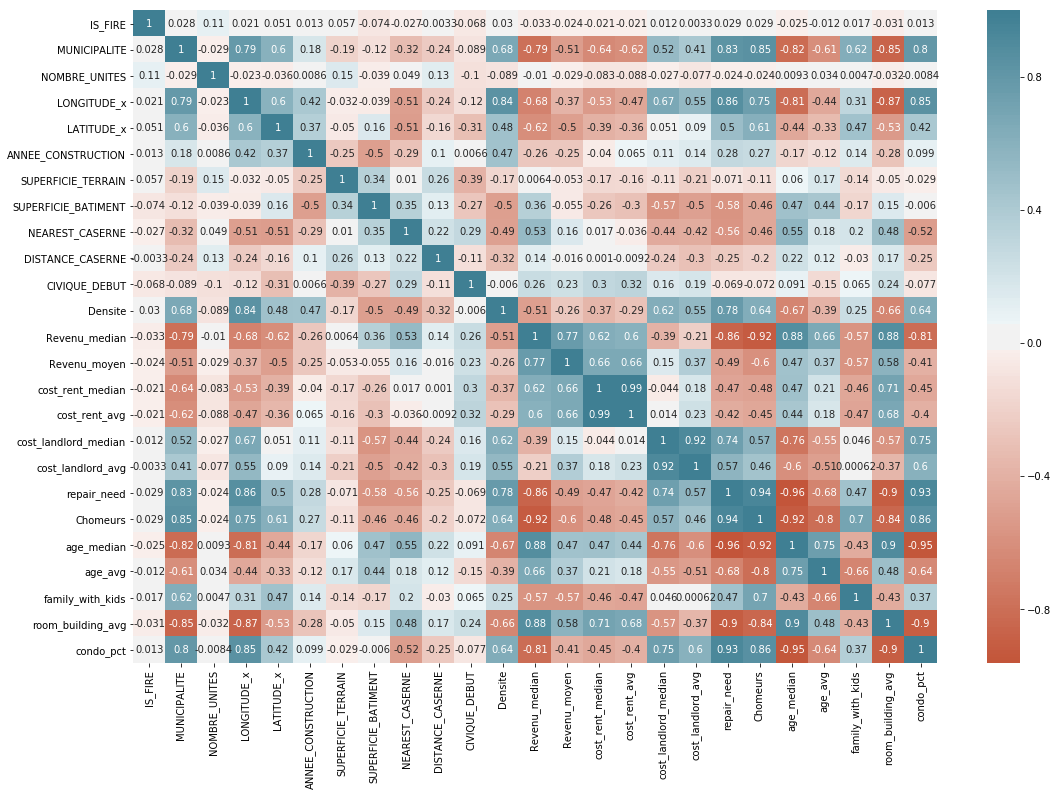

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# create seaborn heatmap
fig = plt.gcf() 
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 3)
sns.heatmap(df_data_all_features_and_target.corr(),annot=True,
           cmap=sns.diverging_palette(20, 220, n=200))

In [0]:
categorical = df_data_all_features_and_target.select_dtypes(include='object').columns


# Hot encode all categorical columns
for i in categorical:
  new_cols = pd.get_dummies(df_data_all_features_and_target[i], prefix=i)
  df_data_all_features_and_target = df_data_all_features_and_target.drop(i, axis=1)
  df_data_all_features_and_target = df_data_all_features_and_target.join(new_cols)

**CREATE train dataset in BigQuery**




In [0]:
%%bigquery --project datacapstoneproject2
CREATE  OR REPLACE TABLE `pompiers.train_dataset`
AS
SELECT * FROM `pompiers.full_join_features_label` 
where INCIDENT_NBR <= (SELECT PERCENTILE_DISC(INCIDENT_NBR, 0.70)  OVER() AS percentile70 FROM `pompiers.full_join_features_label` order BY INCIDENT_NBR asc LIMIT 1)
order BY INCIDENT_NBR asc



""


**CREATE test dataset in BigQuery**

In [0]:
%%bigquery --project datacapstoneproject2
CREATE OR REPLACE TABLE `pompiers.test_dataset`
AS
SELECT * FROM `pompiers.full_join_features_label` 
where INCIDENT_NBR > (SELECT PERCENTILE_DISC(INCIDENT_NBR, 0.70)  OVER() AS percentile70 FROM `pompiers.full_join_features_label` order BY INCIDENT_NBR asc LIMIT 1)
order BY INCIDENT_NBR asc

""


**CREATE classification model in BigQuery**

In [0]:
%%bigquery --project datacapstoneproject2
CREATE OR REPLACE MODEL `pompiers.classification_model`
OPTIONS
(
 model_type='logistic_reg',
 labels = ['IS_FIRE'],
  OPTIMIZE_STRATEGY = 'AUTO_STRATEGY',
  EARLY_STOP = TRUE,
  DATA_SPLIT_METHOD = 'RANDOM',
  DATA_SPLIT_EVAL_FRACTION = 0.7,
  MODEL_PATH = 'gs://datacapstoneproject2/saved_model/ML_fire_detection_classification_model'
)
AS (
  SELECT * EXCEPT(geopoint) FROM `pompiers.train_dataset` 
);

""


**Evaluate classification Model**

In [0]:
%%bigquery --project datacapstoneproject2 df_classification_model_evaluation
SELECT
*,
CASE
WHEN roc_auc > .9 THEN 'good'
WHEN roc_auc > .8 THEN 'fair'
WHEN roc_auc > .7 THEN 'not great'
ELSE 'poor' END AS model_quality
FROM
ML.EVALUATE(MODEL pompiers.classification_model,
(
  SELECT * FROM `pompiers.test_dataset` 
))

In [0]:
df_classification_model_evaluation.head()

,precision,recall,accuracy,f1_score,log_loss,roc_auc,model_quality
0,1.0,0.835052,0.994392,0.910112,0.026648,1.000293,good


**Make prediction**

In [0]:
%%bigquery --project datacapstoneproject2 df_classification_model_prediction
SELECT
  *
FROM
  ML.PREDICT(MODEL `pompiers.classification_model`,
    (
    SELECT * FROM `pompiers.test_dataset`))

In [0]:
df_classification_model_prediction.head()

,predicted_IS_FIRE,predicted_IS_FIRE_probs,INCIDENT_NBR,ARRONDISSEMENT,MUNICIPALITE,RUE,VILLE,CREATION_DATE_TIME,IS_FIRE,INCIDENT_TYPE_DESC,NOM_ARROND,NOMBRE_UNITES,LONGITUDE_x,LATITUDE_x,ANNEE_CONSTRUCTION,LIBELLE_UTILISATION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NEAREST_CASERNE,DISTANCE_CASERNE,CIVIQUE_DEBUT,Densite,Revenu_median,Revenu_moyen,cost_rent_median,cost_rent_avg,cost_landlord_median,cost_landlord_avg,repair_need,Chomeurs,age_median,age_avg,family_with_kids,room_building_avg,condo_pct,geopoint
0,False,"[{'label': True, 'prob': 0.0016613617095939228...",88132,None,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,2015-09-08 11:12:35+00:00,False,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,POINT(-73.950102 45.413436)
1,False,"[{'label': True, 'prob': 0.0014296964971395594...",89814,None,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,2017-09-06 16:00:48+00:00,False,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,POINT(-73.950102 45.413436)
2,False,"[{'label': True, 'prob': 0.0020681396608800092...",95398,None,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,2018-09-25 16:06:15+00:00,False,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,POINT(-73.950102 45.413436)
3,False,"[{'label': True, 'prob': 0.0023796403567358094...",100662,None,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,2016-10-06 20:04:44+00:00,False,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,POINT(-73.950102 45.413436)
4,False,"[{'label': True, 'prob': 0.0017987202476352814...",100886,None,22,boulevard des Anciens-Combattants,SAINTE-ANNE-DE-BELLEVUE,2018-10-11 10:47:45+00:00,False,Premier répondant,Senneville,1.0,-73.950102,45.413436,1962.0,École secondaire,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,POINT(-73.950102 45.413436)


In [0]:
df_data_all_features_and_target.head()

,IS_FIRE,CREATION_DATE_TIME,MUNICIPALITE,NOMBRE_UNITES,LONGITUDE_x,LATITUDE_x,ANNEE_CONSTRUCTION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NEAREST_CASERNE,DISTANCE_CASERNE,CIVIQUE_DEBUT,Densite,Revenu_median,Revenu_moyen,cost_rent_median,cost_rent_avg,cost_landlord_median,cost_landlord_avg,repair_need,Chomeurs,age_median,age_avg,family_with_kids,room_building_avg,condo_pct,ARRONDISSEMENT_AHUNTSIC-CARTIERVILLE,ARRONDISSEMENT_ANJOU,ARRONDISSEMENT_CÔTE-DES-NEIGES-NOTRE-DAME-DE-GRÂCE,ARRONDISSEMENT_LACHINE,ARRONDISSEMENT_LE PLATEAU-MONT-ROYAL,ARRONDISSEMENT_LE SUD-OUEST,ARRONDISSEMENT_MERCIER-HOCHELAGA-MAISONNEUVE,ARRONDISSEMENT_MONTRÉAL-NORD,ARRONDISSEMENT_PIERREFONDS-ROXBORO,ARRONDISSEMENT_ROSEMONT-LA PETITE-PATRIE,ARRONDISSEMENT_SAINT-LAURENT,ARRONDISSEMENT_SAINT-LÉONARD,ARRONDISSEMENT_VERDUN,ARRONDISSEMENT_VILLE-MARIE,...,NOM_ARROND_Montréal-Ouest,NOM_ARROND_Outremont,NOM_ARROND_Pierrefonds-Roxboro,NOM_ARROND_Pointe-Claire,NOM_ARROND_Saint-Laurent,NOM_ARROND_Saint-Léonard,NOM_ARROND_Sainte-Anne-de-Bellevue,NOM_ARROND_Senneville,NOM_ARROND_Verdun,NOM_ARROND_Ville-Marie,NOM_ARROND_Westmount,LIBELLE_UTILISATION_Aréna et activités connexes (patinage sur glace),LIBELLE_UTILISATION_Autres activités reliées au transport par chemin de fer,LIBELLE_UTILISATION_Autres aménagements d'assemblées publiques,LIBELLE_UTILISATION_Autres parcs,LIBELLE_UTILISATION_Autres routes et voies publiques,LIBELLE_UTILISATION_Autres services gouvernementaux,LIBELLE_UTILISATION_Autres services pour le transport,"LIBELLE_UTILISATION_Autres transports, communications et services publics (infrastructure)",LIBELLE_UTILISATION_Aéroport et aérodrome,LIBELLE_UTILISATION_Bibliothèque,LIBELLE_UTILISATION_C.E.G.E.P. (collège d'enseignement général et professionnel),LIBELLE_UTILISATION_Centre commercial régional (100 à 199 magasins),LIBELLE_UTILISATION_Centre d'accueil ou établissement curatif (inclus centre de réadaptation pour handicapés physiques et mentaux),"LIBELLE_UTILISATION_Centre de santé (inclus saunas, spas et bains thérapeutiques ou turcs)","LIBELLE_UTILISATION_Chemin de fer (sauf train touristique, aiguillage et cour de triage)",LIBELLE_UTILISATION_Entreposage de tout genre,LIBELLE_UTILISATION_Espace de terrain non aménagé et non exploité (sauf l'exploitation non commerciale de la forêt),LIBELLE_UTILISATION_Gare de chemins de fer,LIBELLE_UTILISATION_Immeuble à bureaux,LIBELLE_UTILISATION_Installation portuaire en général,LIBELLE_UTILISATION_Logement,LIBELLE_UTILISATION_Maison pour personnes retraitées autonomes,LIBELLE_UTILISATION_Parc d'amusement (extérieur),LIBELLE_UTILISATION_Parc pour la récréation en général,LIBELLE_UTILISATION_Rue et avenue pour l'accès local,LIBELLE_UTILISATION_Service de réparation et d'entretien de véhicules lourds,LIBELLE_UTILISATION_Terrain de stationnement pour automobiles,LIBELLE_UTILISATION_Université,LIBELLE_UTILISATION_École secondaire
0,False,2017-08-15 14:34:22+00:00,22,1.0,-73.958678,45.417060,NaN,238987.0,540.0,51,0.967012,99999,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,False,2017-06-20 14:21:06+00:00,22,1.0,-73.950102,45.413436,1962.0,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,False,2017-03-16 03:12:23+00:00,22,1.0,-73.950102,45.413436,1962.0,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,False,2017-01-30 14:06:05+00:00,22,1.0,-73.950102,45.413436,1962.0,50398.0,6830.0,51,0.134428,300,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### **USING SCIK-LEARN MODELS**

**Import Weather Data**

In [0]:
weather_data = pd.read_csv('https://raw.githubusercontent.com/jackhawa/CapstoneMcgill2019/master/jack/data/weather.csv', encoding='iso-8859-1')
weather_data.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2015-01-01,2015,1,1,NaN,-3.1,NaN,-7.6,NaN,-5.4,NaN,23.4,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,22.0,NaN,41,NaN
1,2015-01-02,2015,1,2,NaN,-3.4,NaN,-13.1,NaN,-8.3,NaN,26.3,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
2,2015-01-03,2015,1,3,NaN,-8.0,NaN,-15.0,NaN,-11.5,NaN,29.5,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,NaN,NaN,<31,NaN
3,2015-01-04,2015,1,4,NaN,3.3,NaN,-8.1,NaN,-2.4,NaN,20.4,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,19.0,NaN,37,NaN
4,2015-01-05,2015,1,5,NaN,-4.8,NaN,-17.5,NaN,-11.2,NaN,29.2,NaN,0.0,NaN,NaN,M,NaN,M,NaN,M,NaN,NaN,18.0,NaN,44,NaN


# Feature Engineering: Create Time Bucket

In [0]:
import holidays
ca_holidays = holidays.CountryHoliday('CA', prov='QC', state=None)

In [0]:
interventions_df = df_data_all_features_and_target
interventions_df['Day'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).day
interventions_df['Month'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).month
interventions_df['Year'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).year
interventions_df['DayOfWeek'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).dayofweek
interventions_df['Time1'] = pd.DatetimeIndex(interventions_df['CREATION_DATE_TIME']).time
interventions_df['Time2'] = '1970-01-01T' + interventions_df['Time1'].map(str)
interventions_df['Time3'] = interventions_df['Time2'].apply(lambda x: np.datetime64(x))
interventions_df['Time4'] = (interventions_df['Time3'] - np.datetime64('1970-01-01 00:00:00')).apply(lambda x: x.total_seconds())
bins = [0, 10800, 21600, 32400, 43200, 54000, 64800,75600.0, 86400.0]
interventions_df['Holiday'] = interventions_df['CREATION_DATE_TIME'].apply(lambda x: x in ca_holidays)
interventions_df['Weekend'] = interventions_df['DayOfWeek'] >= 5
interventions_df['TIME_BUCKET'] = np.searchsorted(bins, interventions_df['Time4'].values)
interventions_df = pd.merge(interventions_df, weather_data,  how='inner', left_on=['Day','Month','Year'], right_on = ['Day','Month','Year'])
interventions_df.head()

,IS_FIRE,CREATION_DATE_TIME,MUNICIPALITE,NOMBRE_UNITES,LONGITUDE_x,LATITUDE_x,ANNEE_CONSTRUCTION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NEAREST_CASERNE,DISTANCE_CASERNE,CIVIQUE_DEBUT,Densite,Revenu_median,Revenu_moyen,cost_rent_median,cost_rent_avg,cost_landlord_median,cost_landlord_avg,repair_need,Chomeurs,age_median,age_avg,family_with_kids,room_building_avg,condo_pct,ARRONDISSEMENT_AHUNTSIC-CARTIERVILLE,ARRONDISSEMENT_ANJOU,ARRONDISSEMENT_CÔTE-DES-NEIGES-NOTRE-DAME-DE-GRÂCE,ARRONDISSEMENT_LACHINE,ARRONDISSEMENT_LE PLATEAU-MONT-ROYAL,ARRONDISSEMENT_LE SUD-OUEST,ARRONDISSEMENT_MERCIER-HOCHELAGA-MAISONNEUVE,ARRONDISSEMENT_MONTRÉAL-NORD,ARRONDISSEMENT_PIERREFONDS-ROXBORO,ARRONDISSEMENT_ROSEMONT-LA PETITE-PATRIE,ARRONDISSEMENT_SAINT-LAURENT,ARRONDISSEMENT_SAINT-LÉONARD,ARRONDISSEMENT_VERDUN,ARRONDISSEMENT_VILLE-MARIE,...,LIBELLE_UTILISATION_Rue et avenue pour l'accès local,LIBELLE_UTILISATION_Service de réparation et d'entretien de véhicules lourds,LIBELLE_UTILISATION_Terrain de stationnement pour automobiles,LIBELLE_UTILISATION_Université,LIBELLE_UTILISATION_École secondaire,Day,Month,Year,DayOfWeek,Time1,Time2,Time3,Time4,Holiday,Weekend,TIME_BUCKET,Date/Time,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,False,2017-08-15 14:34:22+00:00,22,1.0,-73.958678,45.417060,NaN,238987.0,540.0,51,0.967012,99999,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,15,8,2017,1,14:34:22,1970-01-01T14:34:22,1970-01-01 14:34:22,52462.0,False,False,5,2017-08-15,NaN,25.5,NaN,17.7,NaN,21.6,NaN,0.0,NaN,3.6,NaN,NaN,M,NaN,M,5.9,NaN,NaN,NaN,NaN,NaN,<31,NaN
1,False,2017-08-15 19:40:11+00:00,6,1.0,-73.741916,45.448748,2000.0,14415.0,NaN,63,0.724586,755,910.311751,31517.0,38947.0,804.0,871.0,1111.0,1165.0,770.0,650.0,43.8,43.5,3065.0,5.7,0.133492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,15,8,2017,1,19:40:11,1970-01-01T19:40:11,1970-01-01 19:40:11,70811.0,False,False,7,2017-08-15,NaN,25.5,NaN,17.7,NaN,21.6,NaN,0.0,NaN,3.6,NaN,NaN,M,NaN,M,5.9,NaN,NaN,NaN,NaN,NaN,<31,NaN
2,False,2017-08-15 11:54:25+00:00,10,5.0,-73.863982,45.457808,NaN,14170.0,NaN,54,0.931757,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,15,8,2017,1,11:54:25,1970-01-01T11:54:25,1970-01-01 11:54:25,42865.0,False,False,4,2017-08-15,NaN,25.5,NaN,17.7,NaN,21.6,NaN,0.0,NaN,3.6,NaN,NaN,M,NaN,M,5.9,NaN,NaN,NaN,NaN,NaN,<31,NaN
3,False,2017-08-15 10:39:44+00:00,10,1.0,-73.862055,45.447961,NaN,9175.0,NaN,54,0.677465,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,15,8,2017,1,10:39:44,1970-01-01T10:39:44,1970-01-01 10:39:44,38384.0,False,False,4,2017-08-15,NaN,25.5,NaN,17.7,NaN,21.6,NaN,0.0,NaN,3.6,NaN,NaN,M,NaN,M,5.9,NaN,NaN,NaN,NaN,NaN,<31,NaN
4,False,2017-08-15 14:37:49+00:00,50,4.0,-73.702144,45.469999,NaN,20492.0,NaN,64,1.603453,99999,2310.685060,25229.0,33545.0,859.0,910.0,1227.0,1399.0,2535.0,4890.0,38.1,39.0,18780.0,4.9,0.265516,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,15,8,2017,1,14:37:49,1970-01-01T14:37:49,1970-01-01 14:37:49,52669.0,False,False,5,2017-08-15,NaN,25.5,NaN,17.7,NaN,21.6,NaN,0.0,NaN,3.6,NaN,NaN,M,NaN,M,5.9,NaN,NaN,NaN,NaN,NaN,<31,NaN


In [0]:
data_train = interventions_df.drop(['CREATION_DATE_TIME','Time3','Data Quality', 'Time1','Time2','Time4',
                                     'Date/Time','Max Temp Flag','Min Temp Flag','Mean Temp Flag',
                                     'Heat Deg Days Flag','Cool Deg Days Flag','Total Rain (mm)',
                                     'Total Rain Flag','Total Snow (cm)','Total Snow Flag','Total Precip Flag',
                                    'Snow on Grnd (cm)','Snow on Grnd Flag',	'Dir of Max Gust (10s deg)',
                                     'Dir of Max Gust Flag','Spd of Max Gust (km/h)',	'Spd of Max Gust Flag'], axis=1)

In [0]:
data_train.head()

,IS_FIRE,MUNICIPALITE,NOMBRE_UNITES,LONGITUDE_x,LATITUDE_x,ANNEE_CONSTRUCTION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NEAREST_CASERNE,DISTANCE_CASERNE,CIVIQUE_DEBUT,Densite,Revenu_median,Revenu_moyen,cost_rent_median,cost_rent_avg,cost_landlord_median,cost_landlord_avg,repair_need,Chomeurs,age_median,age_avg,family_with_kids,room_building_avg,condo_pct,ARRONDISSEMENT_AHUNTSIC-CARTIERVILLE,ARRONDISSEMENT_ANJOU,ARRONDISSEMENT_CÔTE-DES-NEIGES-NOTRE-DAME-DE-GRÂCE,ARRONDISSEMENT_LACHINE,ARRONDISSEMENT_LE PLATEAU-MONT-ROYAL,ARRONDISSEMENT_LE SUD-OUEST,ARRONDISSEMENT_MERCIER-HOCHELAGA-MAISONNEUVE,ARRONDISSEMENT_MONTRÉAL-NORD,ARRONDISSEMENT_PIERREFONDS-ROXBORO,ARRONDISSEMENT_ROSEMONT-LA PETITE-PATRIE,ARRONDISSEMENT_SAINT-LAURENT,ARRONDISSEMENT_SAINT-LÉONARD,ARRONDISSEMENT_VERDUN,ARRONDISSEMENT_VILLE-MARIE,ARRONDISSEMENT_VILLERAY-SAINT-MICHEL-PARC-EXTENSION,...,LIBELLE_UTILISATION_Autres aménagements d'assemblées publiques,LIBELLE_UTILISATION_Autres parcs,LIBELLE_UTILISATION_Autres routes et voies publiques,LIBELLE_UTILISATION_Autres services gouvernementaux,LIBELLE_UTILISATION_Autres services pour le transport,"LIBELLE_UTILISATION_Autres transports, communications et services publics (infrastructure)",LIBELLE_UTILISATION_Aéroport et aérodrome,LIBELLE_UTILISATION_Bibliothèque,LIBELLE_UTILISATION_C.E.G.E.P. (collège d'enseignement général et professionnel),LIBELLE_UTILISATION_Centre commercial régional (100 à 199 magasins),LIBELLE_UTILISATION_Centre d'accueil ou établissement curatif (inclus centre de réadaptation pour handicapés physiques et mentaux),"LIBELLE_UTILISATION_Centre de santé (inclus saunas, spas et bains thérapeutiques ou turcs)","LIBELLE_UTILISATION_Chemin de fer (sauf train touristique, aiguillage et cour de triage)",LIBELLE_UTILISATION_Entreposage de tout genre,LIBELLE_UTILISATION_Espace de terrain non aménagé et non exploité (sauf l'exploitation non commerciale de la forêt),LIBELLE_UTILISATION_Gare de chemins de fer,LIBELLE_UTILISATION_Immeuble à bureaux,LIBELLE_UTILISATION_Installation portuaire en général,LIBELLE_UTILISATION_Logement,LIBELLE_UTILISATION_Maison pour personnes retraitées autonomes,LIBELLE_UTILISATION_Parc d'amusement (extérieur),LIBELLE_UTILISATION_Parc pour la récréation en général,LIBELLE_UTILISATION_Rue et avenue pour l'accès local,LIBELLE_UTILISATION_Service de réparation et d'entretien de véhicules lourds,LIBELLE_UTILISATION_Terrain de stationnement pour automobiles,LIBELLE_UTILISATION_Université,LIBELLE_UTILISATION_École secondaire,Day,Month,Year,DayOfWeek,Holiday,Weekend,TIME_BUCKET,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Precip (mm)
0,False,22,1.0,-73.958678,45.417060,NaN,238987.0,540.0,51,0.967012,99999,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,5,25.5,17.7,21.6,0.0,3.6,5.9
1,False,6,1.0,-73.741916,45.448748,2000.0,14415.0,NaN,63,0.724586,755,910.311751,31517.0,38947.0,804.0,871.0,1111.0,1165.0,770.0,650.0,43.8,43.5,3065.0,5.7,0.133492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,7,25.5,17.7,21.6,0.0,3.6,5.9
2,False,10,5.0,-73.863982,45.457808,NaN,14170.0,NaN,54,0.931757,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,4,25.5,17.7,21.6,0.0,3.6,5.9
3,False,10,1.0,-73.862055,45.447961,NaN,9175.0,NaN,54,0.677465,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,4,25.5,17.7,21.6,0.0,3.6,5.9
4,False,50,4.0,-73.702144,45.469999,NaN,20492.0,NaN,64,1.603453,99999,2310.685060,25229.0,33545.0,859.0,910.0,1227

In [0]:
data_train = pd.DataFrame(data_train).fillna(data_train.mean())
data_train.head()

,IS_FIRE,MUNICIPALITE,NOMBRE_UNITES,LONGITUDE_x,LATITUDE_x,ANNEE_CONSTRUCTION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NEAREST_CASERNE,DISTANCE_CASERNE,CIVIQUE_DEBUT,Densite,Revenu_median,Revenu_moyen,cost_rent_median,cost_rent_avg,cost_landlord_median,cost_landlord_avg,repair_need,Chomeurs,age_median,age_avg,family_with_kids,room_building_avg,condo_pct,ARRONDISSEMENT_AHUNTSIC-CARTIERVILLE,ARRONDISSEMENT_ANJOU,ARRONDISSEMENT_CÔTE-DES-NEIGES-NOTRE-DAME-DE-GRÂCE,ARRONDISSEMENT_LACHINE,ARRONDISSEMENT_LE PLATEAU-MONT-ROYAL,ARRONDISSEMENT_LE SUD-OUEST,ARRONDISSEMENT_MERCIER-HOCHELAGA-MAISONNEUVE,ARRONDISSEMENT_MONTRÉAL-NORD,ARRONDISSEMENT_PIERREFONDS-ROXBORO,ARRONDISSEMENT_ROSEMONT-LA PETITE-PATRIE,ARRONDISSEMENT_SAINT-LAURENT,ARRONDISSEMENT_SAINT-LÉONARD,ARRONDISSEMENT_VERDUN,ARRONDISSEMENT_VILLE-MARIE,ARRONDISSEMENT_VILLERAY-SAINT-MICHEL-PARC-EXTENSION,...,LIBELLE_UTILISATION_Autres aménagements d'assemblées publiques,LIBELLE_UTILISATION_Autres parcs,LIBELLE_UTILISATION_Autres routes et voies publiques,LIBELLE_UTILISATION_Autres services gouvernementaux,LIBELLE_UTILISATION_Autres services pour le transport,"LIBELLE_UTILISATION_Autres transports, communications et services publics (infrastructure)",LIBELLE_UTILISATION_Aéroport et aérodrome,LIBELLE_UTILISATION_Bibliothèque,LIBELLE_UTILISATION_C.E.G.E.P. (collège d'enseignement général et professionnel),LIBELLE_UTILISATION_Centre commercial régional (100 à 199 magasins),LIBELLE_UTILISATION_Centre d'accueil ou établissement curatif (inclus centre de réadaptation pour handicapés physiques et mentaux),"LIBELLE_UTILISATION_Centre de santé (inclus saunas, spas et bains thérapeutiques ou turcs)","LIBELLE_UTILISATION_Chemin de fer (sauf train touristique, aiguillage et cour de triage)",LIBELLE_UTILISATION_Entreposage de tout genre,LIBELLE_UTILISATION_Espace de terrain non aménagé et non exploité (sauf l'exploitation non commerciale de la forêt),LIBELLE_UTILISATION_Gare de chemins de fer,LIBELLE_UTILISATION_Immeuble à bureaux,LIBELLE_UTILISATION_Installation portuaire en général,LIBELLE_UTILISATION_Logement,LIBELLE_UTILISATION_Maison pour personnes retraitées autonomes,LIBELLE_UTILISATION_Parc d'amusement (extérieur),LIBELLE_UTILISATION_Parc pour la récréation en général,LIBELLE_UTILISATION_Rue et avenue pour l'accès local,LIBELLE_UTILISATION_Service de réparation et d'entretien de véhicules lourds,LIBELLE_UTILISATION_Terrain de stationnement pour automobiles,LIBELLE_UTILISATION_Université,LIBELLE_UTILISATION_École secondaire,Day,Month,Year,DayOfWeek,Holiday,Weekend,TIME_BUCKET,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Precip (mm)
0,False,22,1.0,-73.958678,45.417060,1970.030336,238987.0,540.000000,51,0.967012,99999,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,5,25.5,17.7,21.6,0.0,3.6,5.9
1,False,6,1.0,-73.741916,45.448748,2000.000000,14415.0,39478.808913,63,0.724586,755,910.311751,31517.0,38947.0,804.0,871.0,1111.0,1165.0,770.0,650.0,43.8,43.5,3065.0,5.7,0.133492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,7,25.5,17.7,21.6,0.0,3.6,5.9
2,False,10,5.0,-73.863982,45.457808,1970.030336,14170.0,39478.808913,54,0.931757,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,4,25.5,17.7,21.6,0.0,3.6,5.9
3,False,10,1.0,-73.862055,45.447961,1970.030336,9175.0,39478.808913,54,0.677465,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,4,25.5,17.7,21.6,0.0,3.6,5.9
4,False,50,4.0,-73.702144,45.469999,1970.030336,20492

**Showing  Imbalanced data: Fire Count Frequency**

False    9157
True      356
Name: IS_FIRE, dtype: int64

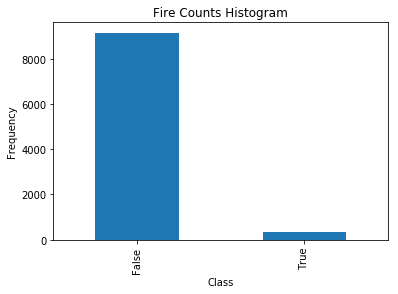

In [0]:
y_train = data_train['IS_FIRE']

pd.value_counts(y_train).plot.bar()
plt.title('Fire Counts Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
y_train.value_counts()

In [0]:
#data_train_x = data_train.drop(['IS_FIRE'], axis=1)
data_train_x = data_train
data_train_x['Month'] = data_train_x['Month'].astype(object)
data_train_x['DayOfWeek'] = data_train_x['DayOfWeek'].astype(object)
data_train_x['TIME_BUCKET'] = data_train_x['TIME_BUCKET'].astype(object)
X_train = data_train_x

X_train.head()

,IS_FIRE,MUNICIPALITE,NOMBRE_UNITES,LONGITUDE_x,LATITUDE_x,ANNEE_CONSTRUCTION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NEAREST_CASERNE,DISTANCE_CASERNE,CIVIQUE_DEBUT,Densite,Revenu_median,Revenu_moyen,cost_rent_median,cost_rent_avg,cost_landlord_median,cost_landlord_avg,repair_need,Chomeurs,age_median,age_avg,family_with_kids,room_building_avg,condo_pct,ARRONDISSEMENT_AHUNTSIC-CARTIERVILLE,ARRONDISSEMENT_ANJOU,ARRONDISSEMENT_CÔTE-DES-NEIGES-NOTRE-DAME-DE-GRÂCE,ARRONDISSEMENT_LACHINE,ARRONDISSEMENT_LE PLATEAU-MONT-ROYAL,ARRONDISSEMENT_LE SUD-OUEST,ARRONDISSEMENT_MERCIER-HOCHELAGA-MAISONNEUVE,ARRONDISSEMENT_MONTRÉAL-NORD,ARRONDISSEMENT_PIERREFONDS-ROXBORO,ARRONDISSEMENT_ROSEMONT-LA PETITE-PATRIE,ARRONDISSEMENT_SAINT-LAURENT,ARRONDISSEMENT_SAINT-LÉONARD,ARRONDISSEMENT_VERDUN,ARRONDISSEMENT_VILLE-MARIE,ARRONDISSEMENT_VILLERAY-SAINT-MICHEL-PARC-EXTENSION,...,LIBELLE_UTILISATION_Autres aménagements d'assemblées publiques,LIBELLE_UTILISATION_Autres parcs,LIBELLE_UTILISATION_Autres routes et voies publiques,LIBELLE_UTILISATION_Autres services gouvernementaux,LIBELLE_UTILISATION_Autres services pour le transport,"LIBELLE_UTILISATION_Autres transports, communications et services publics (infrastructure)",LIBELLE_UTILISATION_Aéroport et aérodrome,LIBELLE_UTILISATION_Bibliothèque,LIBELLE_UTILISATION_C.E.G.E.P. (collège d'enseignement général et professionnel),LIBELLE_UTILISATION_Centre commercial régional (100 à 199 magasins),LIBELLE_UTILISATION_Centre d'accueil ou établissement curatif (inclus centre de réadaptation pour handicapés physiques et mentaux),"LIBELLE_UTILISATION_Centre de santé (inclus saunas, spas et bains thérapeutiques ou turcs)","LIBELLE_UTILISATION_Chemin de fer (sauf train touristique, aiguillage et cour de triage)",LIBELLE_UTILISATION_Entreposage de tout genre,LIBELLE_UTILISATION_Espace de terrain non aménagé et non exploité (sauf l'exploitation non commerciale de la forêt),LIBELLE_UTILISATION_Gare de chemins de fer,LIBELLE_UTILISATION_Immeuble à bureaux,LIBELLE_UTILISATION_Installation portuaire en général,LIBELLE_UTILISATION_Logement,LIBELLE_UTILISATION_Maison pour personnes retraitées autonomes,LIBELLE_UTILISATION_Parc d'amusement (extérieur),LIBELLE_UTILISATION_Parc pour la récréation en général,LIBELLE_UTILISATION_Rue et avenue pour l'accès local,LIBELLE_UTILISATION_Service de réparation et d'entretien de véhicules lourds,LIBELLE_UTILISATION_Terrain de stationnement pour automobiles,LIBELLE_UTILISATION_Université,LIBELLE_UTILISATION_École secondaire,Day,Month,Year,DayOfWeek,Holiday,Weekend,TIME_BUCKET,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Precip (mm)
0,False,22,1.0,-73.958678,45.417060,1970.030336,238987.0,540.000000,51,0.967012,99999,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,5,25.5,17.7,21.6,0.0,3.6,5.9
1,False,6,1.0,-73.741916,45.448748,2000.000000,14415.0,39478.808913,63,0.724586,755,910.311751,31517.0,38947.0,804.0,871.0,1111.0,1165.0,770.0,650.0,43.8,43.5,3065.0,5.7,0.133492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,7,25.5,17.7,21.6,0.0,3.6,5.9
2,False,10,5.0,-73.863982,45.457808,1970.030336,14170.0,39478.808913,54,0.931757,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,4,25.5,17.7,21.6,0.0,3.6,5.9
3,False,10,1.0,-73.862055,45.447961,1970.030336,9175.0,39478.808913,54,0.677465,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,4,25.5,17.7,21.6,0.0,3.6,5.9
4,False,50,4.0,-73.702144,45.469999,1970.030336,20492

In [0]:
X_train[:] = np.nan_to_num(X_train)
X_train.fillna(0)

,IS_FIRE,MUNICIPALITE,NOMBRE_UNITES,LONGITUDE_x,LATITUDE_x,ANNEE_CONSTRUCTION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NEAREST_CASERNE,DISTANCE_CASERNE,CIVIQUE_DEBUT,Densite,Revenu_median,Revenu_moyen,cost_rent_median,cost_rent_avg,cost_landlord_median,cost_landlord_avg,repair_need,Chomeurs,age_median,age_avg,family_with_kids,room_building_avg,condo_pct,ARRONDISSEMENT_AHUNTSIC-CARTIERVILLE,ARRONDISSEMENT_ANJOU,ARRONDISSEMENT_CÔTE-DES-NEIGES-NOTRE-DAME-DE-GRÂCE,ARRONDISSEMENT_LACHINE,ARRONDISSEMENT_LE PLATEAU-MONT-ROYAL,ARRONDISSEMENT_LE SUD-OUEST,ARRONDISSEMENT_MERCIER-HOCHELAGA-MAISONNEUVE,ARRONDISSEMENT_MONTRÉAL-NORD,ARRONDISSEMENT_PIERREFONDS-ROXBORO,ARRONDISSEMENT_ROSEMONT-LA PETITE-PATRIE,ARRONDISSEMENT_SAINT-LAURENT,ARRONDISSEMENT_SAINT-LÉONARD,ARRONDISSEMENT_VERDUN,ARRONDISSEMENT_VILLE-MARIE,ARRONDISSEMENT_VILLERAY-SAINT-MICHEL-PARC-EXTENSION,...,LIBELLE_UTILISATION_Autres aménagements d'assemblées publiques,LIBELLE_UTILISATION_Autres parcs,LIBELLE_UTILISATION_Autres routes et voies publiques,LIBELLE_UTILISATION_Autres services gouvernementaux,LIBELLE_UTILISATION_Autres services pour le transport,"LIBELLE_UTILISATION_Autres transports, communications et services publics (infrastructure)",LIBELLE_UTILISATION_Aéroport et aérodrome,LIBELLE_UTILISATION_Bibliothèque,LIBELLE_UTILISATION_C.E.G.E.P. (collège d'enseignement général et professionnel),LIBELLE_UTILISATION_Centre commercial régional (100 à 199 magasins),LIBELLE_UTILISATION_Centre d'accueil ou établissement curatif (inclus centre de réadaptation pour handicapés physiques et mentaux),"LIBELLE_UTILISATION_Centre de santé (inclus saunas, spas et bains thérapeutiques ou turcs)","LIBELLE_UTILISATION_Chemin de fer (sauf train touristique, aiguillage et cour de triage)",LIBELLE_UTILISATION_Entreposage de tout genre,LIBELLE_UTILISATION_Espace de terrain non aménagé et non exploité (sauf l'exploitation non commerciale de la forêt),LIBELLE_UTILISATION_Gare de chemins de fer,LIBELLE_UTILISATION_Immeuble à bureaux,LIBELLE_UTILISATION_Installation portuaire en général,LIBELLE_UTILISATION_Logement,LIBELLE_UTILISATION_Maison pour personnes retraitées autonomes,LIBELLE_UTILISATION_Parc d'amusement (extérieur),LIBELLE_UTILISATION_Parc pour la récréation en général,LIBELLE_UTILISATION_Rue et avenue pour l'accès local,LIBELLE_UTILISATION_Service de réparation et d'entretien de véhicules lourds,LIBELLE_UTILISATION_Terrain de stationnement pour automobiles,LIBELLE_UTILISATION_Université,LIBELLE_UTILISATION_École secondaire,Day,Month,Year,DayOfWeek,Holiday,Weekend,TIME_BUCKET,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Precip (mm)
0,False,22,1.0,-73.958678,45.417060,1970.030336,238987.0,540.000000,51,0.967012,99999,123.342708,36718.0,68443.0,850.0,868.0,1251.0,1600.0,20.0,15.0,48.3,44.6,170.0,9.0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,5,25.50000,17.7,21.600000,0.000000,3.600000,5.900000
1,False,6,1.0,-73.741916,45.448748,2000.000000,14415.0,39478.808913,63,0.724586,755,910.311751,31517.0,38947.0,804.0,871.0,1111.0,1165.0,770.0,650.0,43.8,43.5,3065.0,5.7,0.133492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,7,25.50000,17.7,21.600000,0.000000,3.600000,5.900000
2,False,10,5.0,-73.863982,45.457808,1970.030336,14170.0,39478.808913,54,0.931757,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,4,25.50000,17.7,21.600000,0.000000,3.600000,5.900000
3,False,10,1.0,-73.862055,45.447961,1970.030336,9175.0,39478.808913,54,0.677465,99999,2093.827930,34772.0,46175.0,1093.0,1240.0,1158.0,1374.0,290.0,665.0,45.2,41.9,4085.0,8.3,0.071055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,8,2017,1,False,False,4,25.50000

**Applying SMOTE for oversampling**

In [0]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)
X = X_sm
y = y_sm

### **Data no longer imbalanced**

True     9157
False    9157
dtype: int64

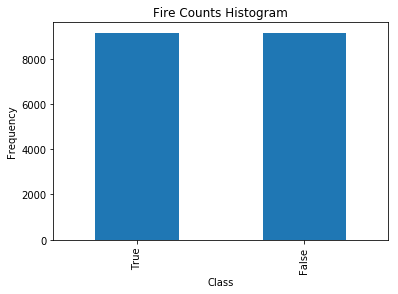

In [0]:
pd.value_counts(y_sm).plot.bar()
plt.title('Fire Counts Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
pd.value_counts(y_sm)

**Training multiple classifiers**

In [0]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [0]:
X_train = X_train.reset_index()

In [0]:
from sklearn.model_selection import train_test_split

y_train = X_train['IS_FIRE']
X_train = X_train.drop(['IS_FIRE'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_train, test_size=0.2)

In [0]:
#X_sm['ind_all'] = (pd.DataFrame(X_sm).iloc[:, 5:16] == 1).idxmax(1)
#pd.DataFrame(X_sm).iloc[:, 5:17].head()

In [0]:
X_train.shape

(7610, 242)

In [0]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd_test = round(sgd.score(X_test, Y_test) * 100, 2)

In [0]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train, )

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest_test = round(random_forest.score(X_test, Y_test) * 100, 2)

In [0]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log_test = round(logreg.score(X_test, Y_test) * 100, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian_test = round(gaussian.score(X_test, Y_test) * 100, 2)

In [0]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc_test = round(linear_svc.score(X_test, Y_test) * 100, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree_test = round(decision_tree.score(X_test, Y_test) * 100, 2)

In [0]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron_test = round(perceptron.score(X_test, Y_test) * 100, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


# **Comparing performance**

In [0]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Training Score': [acc_linear_svc, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree],
    'Testing Score': [acc_linear_svc_test, acc_log_test, 
              acc_random_forest_test, acc_gaussian_test, acc_perceptron_test, 
              acc_sgd_test, acc_decision_tree_test]})
result_df = results.sort_values(by='Testing Score', ascending=False)
result_df = result_df.set_index('Testing Score')
result_df.head(9)

,Model,Training Score
Testing Score,,
99.89,Decision Tree,100.00
99.42,Random Forest,100.00
95.90,Support Vector Machines,96.35
95.90,Logistic Regression,96.35
95.90,Perceptron,96.35
95.90,Stochastic Gradient Decent,96.35
92.22,Naive Bayes,92.75


# **Performing K-Fold Cross Validation on Random Forest Model**

In [0]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99343832 0.99343832 0.99605782 0.9934297  0.99868594 0.99211564
 0.99605782 0.99737188 0.99605263 0.99605263]
Mean: 0.9952700694642231
Standard Deviation: 0.001964680573492795


# **Confusion Matrix**

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[7330,    2],
       [  47,  231]])

# **Precision, Recall, and F1 Score**

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))
print("F1 Score:", f1_score(Y_train, predictions))

Precision: 0.9914163090128756
Recall: 0.8309352517985612
F1 Score: 0.9041095890410961


# **Precision / Recall Curve to identify Best Threshold**

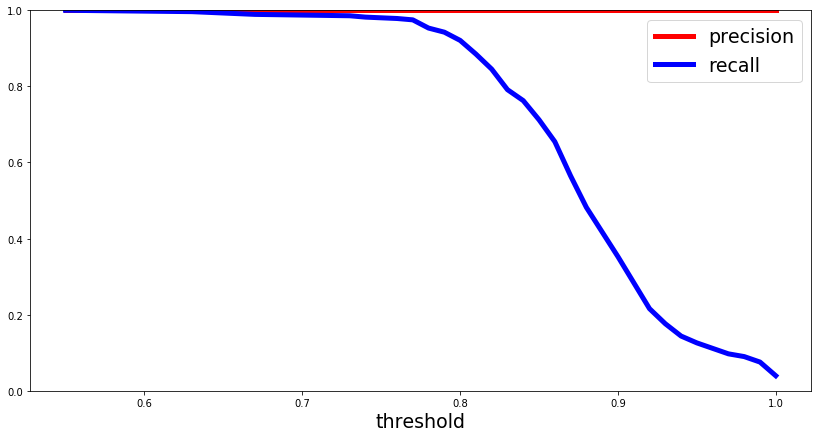

In [0]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

# **ROC Curve**

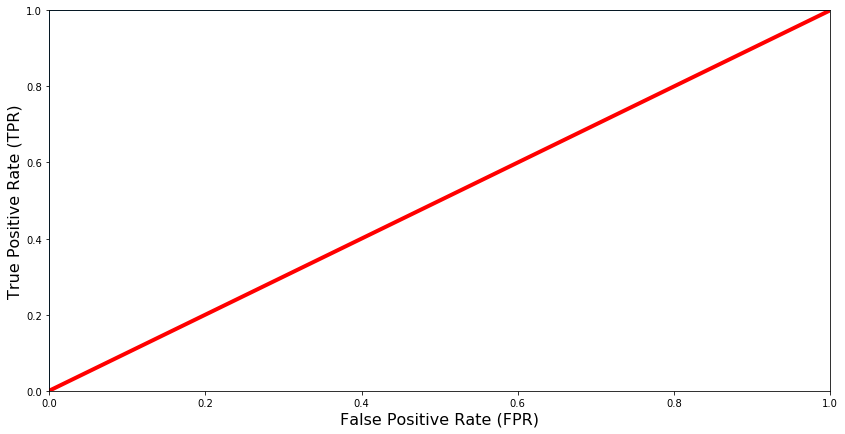

In [0]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 1.0


# **Predicting Fire Probability**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

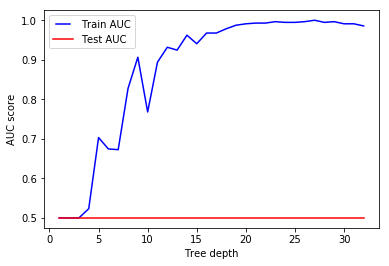

In [0]:
from sklearn.metrics import roc_curve, auc

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, Y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

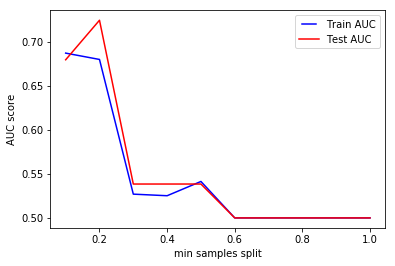

In [0]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train, Y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

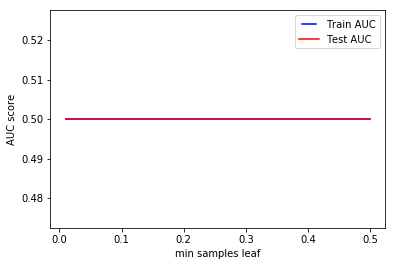

In [0]:
min_samples_leafs = np.linspace(0.01, 0.5, 15, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(X_train, Y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

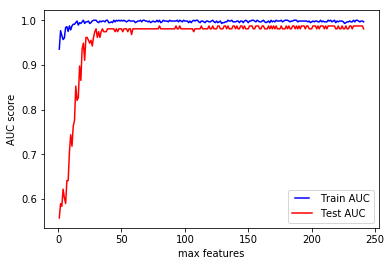

In [0]:
max_features = list(range(1,X_sm.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature)
   rf.fit(X_train, Y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()